## In this notebook, we will explore ARIMA.

# ARIMA
Autoregressive Integrated Moving Average (ARIMA) is a commonly-used local statistical algorithm for time-series forecasting. ARIMA captures standard temporal structures (patterned organizations of time) in the input dataset. 

The ARIMA algorithm is especially useful for datasets that can be mapped to stationary time series. The statistical properties of stationary time series, such as autocorrelations, are independent of time. Datasets with stationary time series usually contain a combination of signal and noise. The signal may exhibit a pattern of sinusoidal oscillation or have a seasonal component. ARIMA acts like a filter to separate the signal from the noise, and then extrapolates the signal in the future to make predictions.

We will use statsmodels to explore ARIMA first. [Statsmodels](https://www.statsmodels.org/stable/about.html#module-statsmodels) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. 

In [1]:
%matplotlib inline

import sys
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from decouple import config
rcParams['figure.figsize'] = 15, 6

In [2]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

In [3]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
start_predict = pd.Timestamp(DATETIME_START_OF_PREDICT, freq=freq)
end_predict = pd.Timestamp(DATETIME_END_OF_PREDICT, freq=freq)

Read time series data from csv. Then convert dataframe to a list with datetime index.

In [4]:
FILE_NAME = 'data/timeseries_raw.csv'

In [5]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

As there are 1604 stores in the data, we can use index from timeseries to extract one store's sales data. Here we use store 88 for example, you can try other id. 

In [6]:
import statsmodels.api as sm

Plot the data first.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


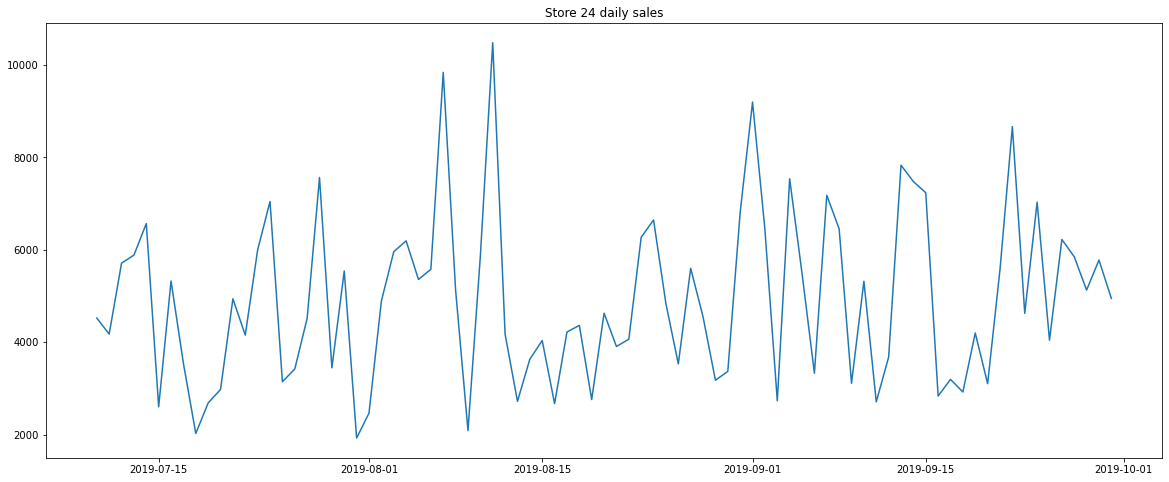

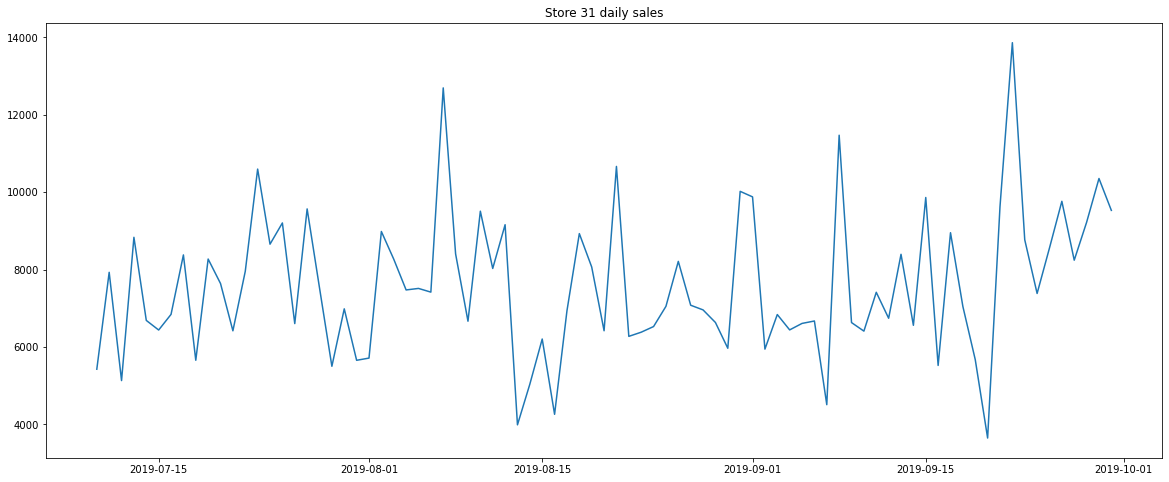

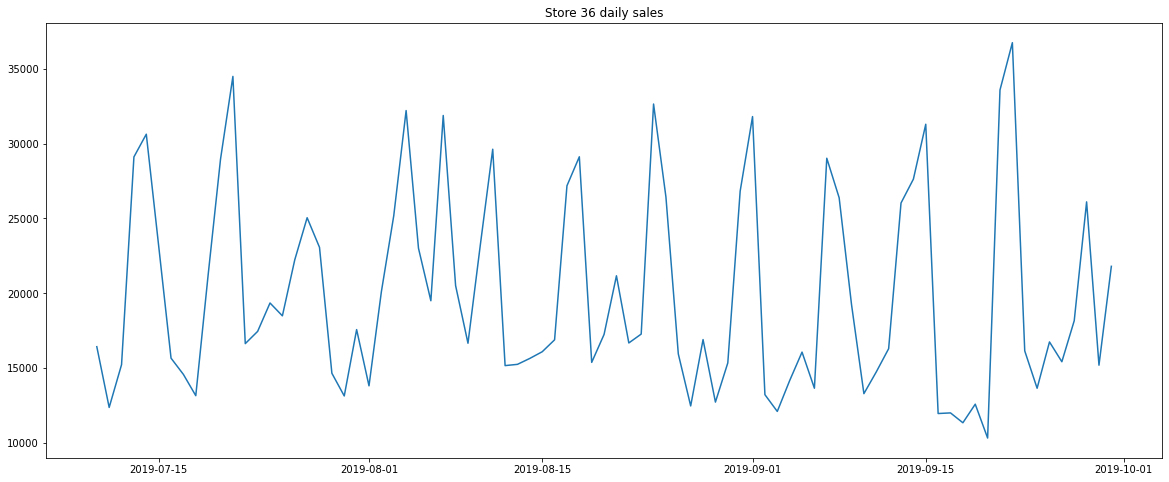

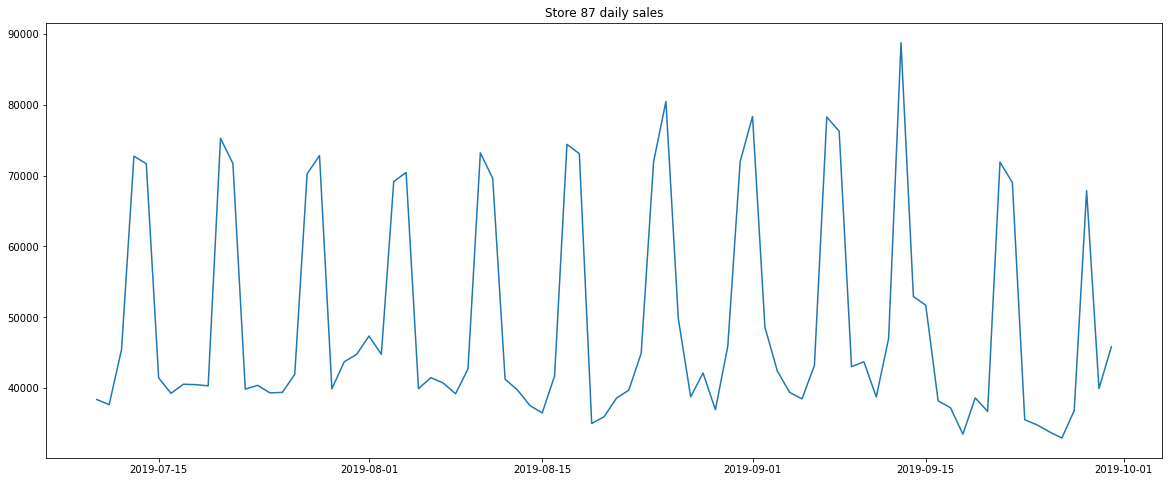

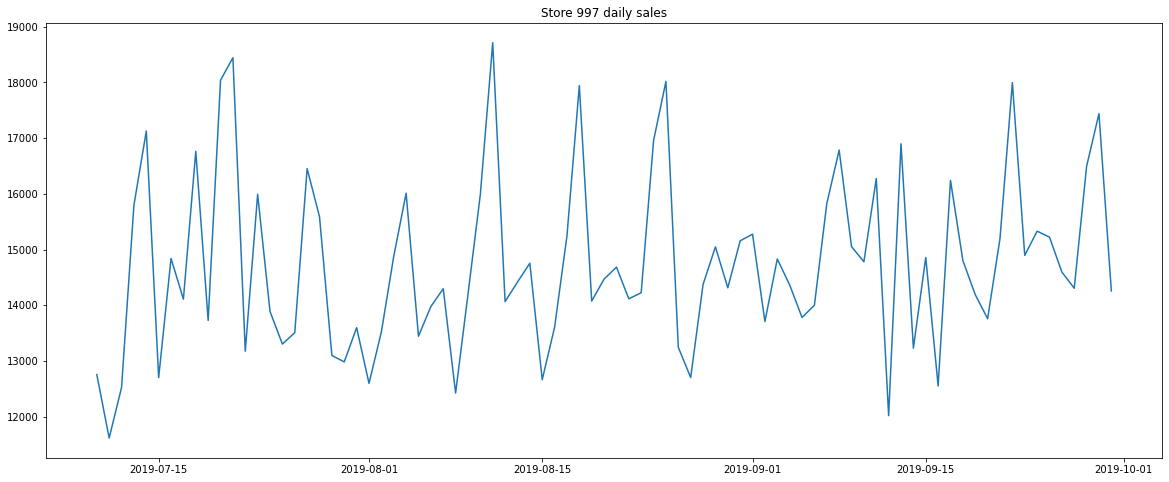

In [7]:
for i in sample_sites:
    ts = timeseries[i]
    fig = plt.figure(figsize=(20, 8))
    plt.plot(ts)
    plt.title('Store %s daily sales'%i)
    plt.show()

We can see it looks like stationary, but with a little trend, we can use Dickey-Fuller Test to caculate the truth.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model. [For more introduce](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

So for us, we need determine the value of (p,d,q).

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

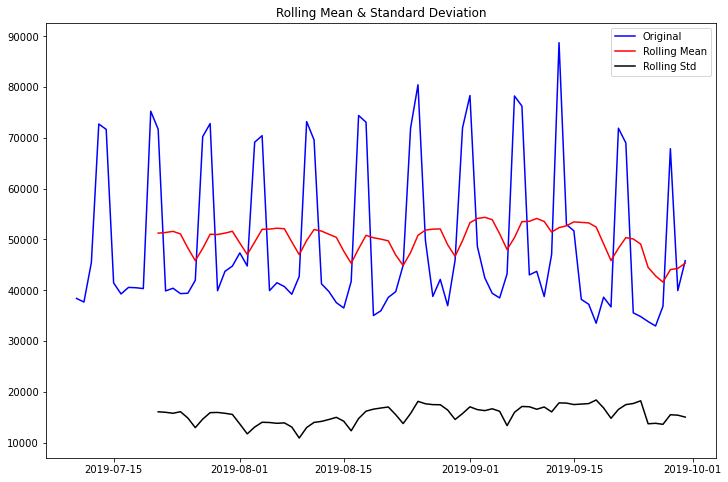

Results of Dickey-Fuller Test:
Test Statistic                 -1.927898
p-value                         0.319053
#Lags Used                      6.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


In [9]:
# choose timeseries[87] for example
ts = timeseries[87]
test_stationarity(ts)

The p-value is not less than 0.05, let's do order 1 diff.

<AxesSubplot:>

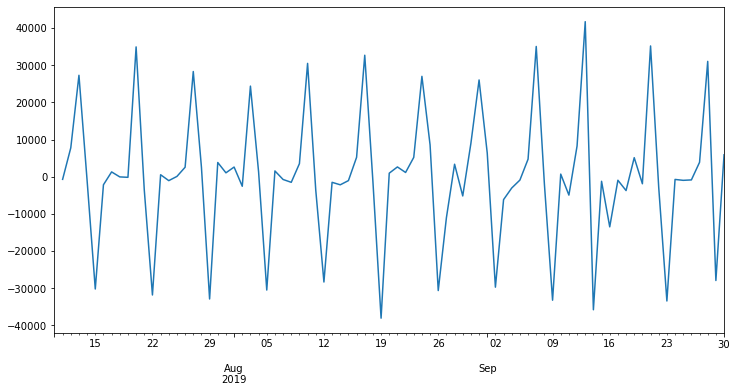

In [10]:
diff1 = ts.diff(1)
diff1.plot(figsize=(12,6))

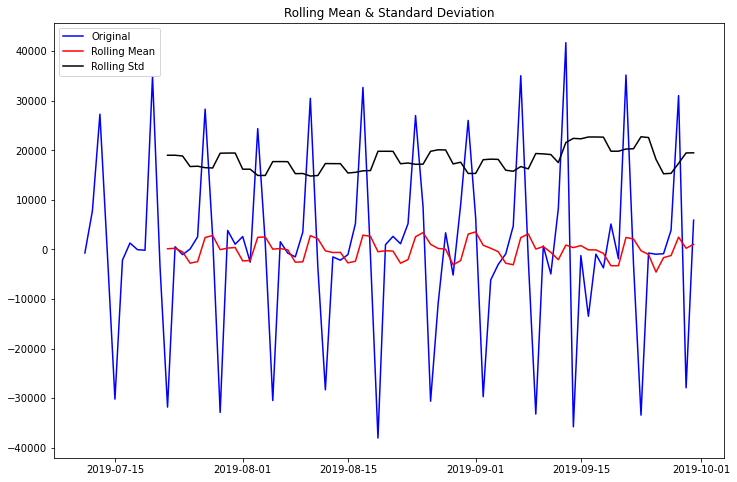

Results of Dickey-Fuller Test:
Test Statistic                 -4.053413
p-value                         0.001155
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [11]:
test_stationarity(diff1.dropna(inplace=False))

Now the p-value < 0.05 and Test Statistic < Critical Value (5%), we can use d = 1.

Plot ACF and PACF to find best value for p,q.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


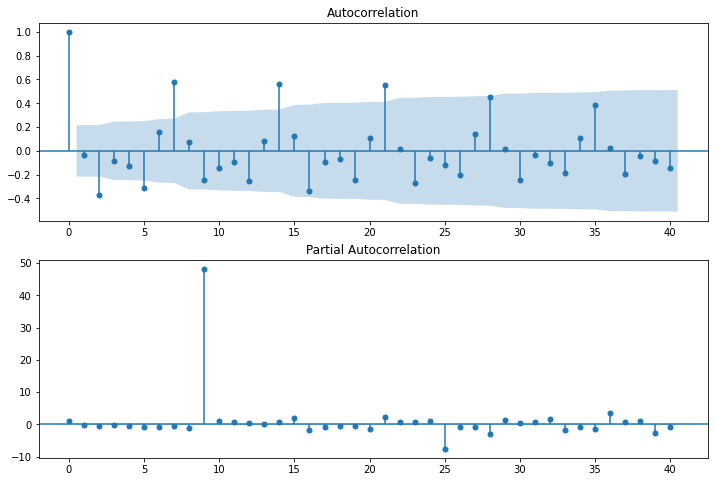

In [12]:
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

Try (p,d,q) = (3,1,0) first

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [14]:
# contrived dataset
df_train = ts[start_dataset:start_predict-1]
df_predict=ts[start_predict:end_predict-1]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()


In [15]:
# fit model
model = ARIMA(df_train, order=(3, 1, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=start_predict, end=end_predict-1,typ='levels')
print(yhat)

2019-09-24    34027.616438
2019-09-25    48483.376206
2019-09-26    52706.455059
2019-09-27    46733.943009
2019-09-28    43508.285335
2019-09-29    45692.367941
2019-09-30    47754.139675
Freq: D, dtype: float64


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Addition/subtraction of integers 

In [16]:
model_fit.params

const         43.408385
ar.L1.D.87    -0.048820
ar.L2.D.87    -0.417028
ar.L3.D.87    -0.126261
dtype: float64

Plot the predict result with groundtruth.

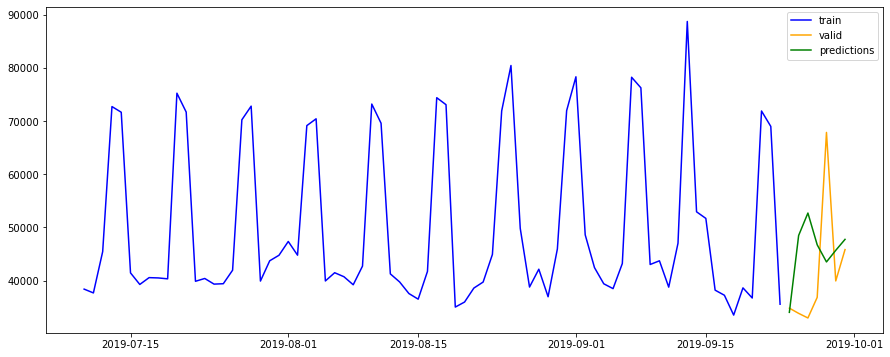

In [17]:
rcParams['figure.figsize'] = 15, 6
train_data = plt.plot(df_train, color='blue',label="train")
valid_data = plt.plot(df_predict, color='orange',label="valid")
predict_data = plt.plot(yhat, color='green',label="predictions")
plt.legend(loc="best")
plt.show()

You can try diffenent combination of (p,d,q), it is really hard to choose the value of (p,d,q), the good thing is we have **auto arima** to help us to choose, next we will show this.

In [18]:
# if you get an error about not install setuptools-git, then run under command.
#!pip install setuptools-git

In [22]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 6.4 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [23]:
import pmdarima as pm


We can assign the start value and max value of (p,d,q), then it will search the proper value for us. For params specific, check http://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

We will consider weekly seasonal. 

In [24]:
model = pm.auto_arima(df_train, trace=True, seasonal=True, d=1, start_p=1, max_p =10, start_q=1, max_q=10, m=7, maxiter=500, random=False, n_fits=100, n_jobs =8, information_criterion ='bic', error_action='ignore', suppress_warning=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1688.582, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1668.822, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1684.271, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1692.906, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=1663.029, Time=0.16 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=1665.828, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=1662.696, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=1681.384, Time=0.08 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : BIC=1665.890, Time=0.24 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : BIC=1674.316, Time=0.14 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : BIC=1642.683, Time=1.10 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : BIC=1666.350, Time=0.30 sec
 ARIMA(2,1,0)(2,0,2)[7] intercept   : BIC=1

In [25]:
forecast = model.predict(n_periods=7)
forecast

array([34745.22101354, 29736.83638375, 33811.72014195, 58220.63611305,
       45741.72066641, 43268.75424293, 25872.3884784 ])

In [26]:
model.params()

array([-7.43213922e+02, -1.93277046e-01,  4.94543171e-01,  3.92691193e-01,
       -4.33963698e-01,  1.67362409e-01,  1.15842083e+08])

Show out modle's parameters.

In [27]:
model.get_params()['order']

(1, 1, 0)

In [28]:
def plot_predictions(forecast,store_id):
    ts = timeseries[store_id]
    df_train = ts[start_dataset:start_predict-1]
    df_predict=ts[start_predict:end_predict-1]
    
    rcParams['figure.figsize'] = 15, 6
    forecast = pd.DataFrame(forecast, index=df_predict.index, columns=['Predictions'])
    train_data = plt.plot(df_train, color='blue',label="train")
    valid_data = plt.plot(df_predict, color='orange',label="valid")
    predict_data = plt.plot(forecast, color='green',label="predictions")
    plt.title('Store %s prediction result' %store_id)
    plt.legend(loc="best")
    plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


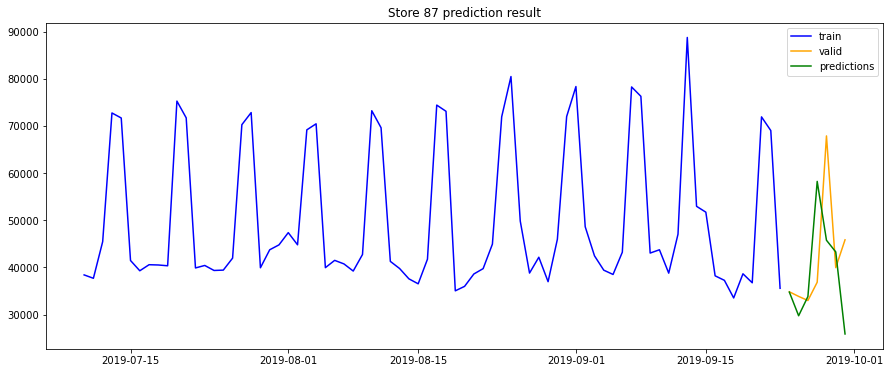

In [29]:
plot_predictions(forecast,87)

It fits better than before.

Now You can try other values combination or other time series, here we just want to show how to use it. We will plot 4 timeseries for example.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1391.530, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1394.207, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1387.219, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : BIC=1395.295, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : BIC=1395.484, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1390.525, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.997 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


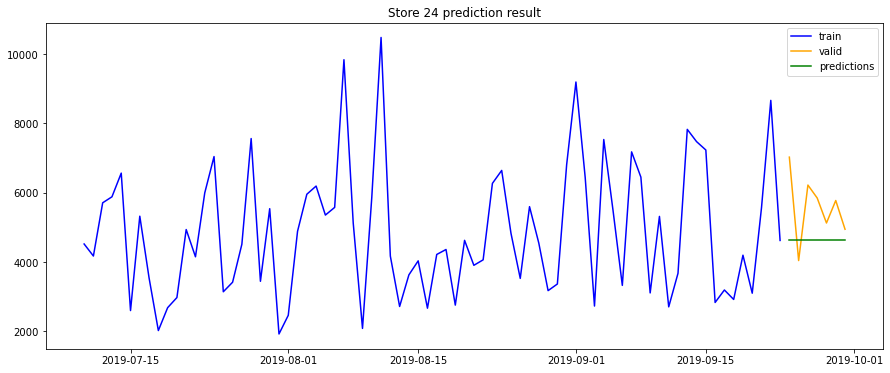

Order value for store 24 prediction is:

order :  (0, 1, 0)
seasonal_order :  (0, 0, 0, 7)
Performing stepwise search to minimize bic


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1400.012, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1392.533, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1395.724, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1388.628, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=1392.696, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=1392.662, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : BIC=1382.688, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : BIC=1386.915, Time=0.07 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : BIC=1386.953, Time=0.08 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : BIC=1391.167, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[7] intercept   : BIC=1384.789, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[7] interc

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


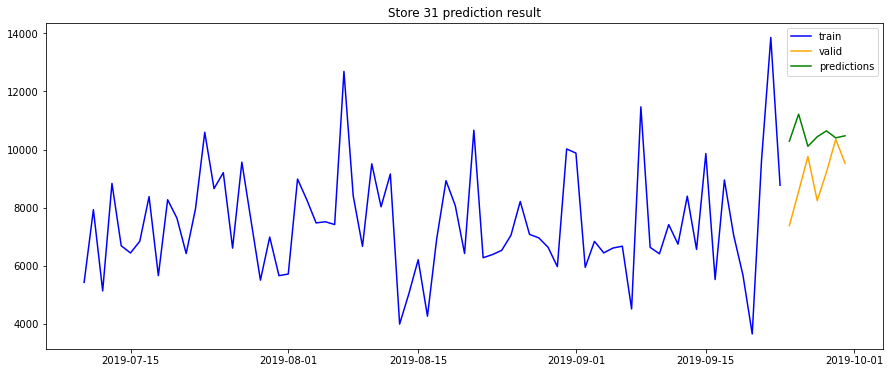

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Order value for store 31 prediction is:

order :  (2, 1, 0)
seasonal_order :  (0, 0, 0, 7)
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1570.394, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1547.964, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1566.083, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1574.336, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=1522.247, Time=0.50 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=1515.968, Time=1.07 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=1538.407, Time=0.37 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : BIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : BIC=1516.065, Time=1.12 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : BIC=1518.198, Time=0.79 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : BIC=1519.007, Time=1.46 sec
 ARIMA(1,1,1)(2,0,1)[7]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


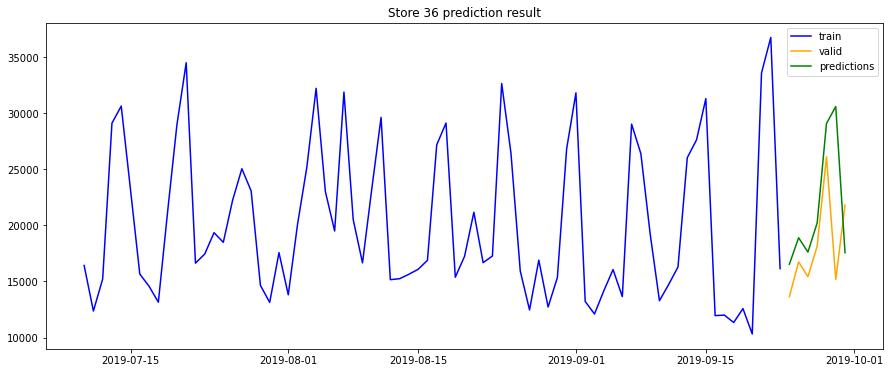

Order value for store 36 prediction is:

order :  (1, 1, 0)
seasonal_order :  (2, 0, 1, 7)
Performing stepwise search to minimize bic


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1688.582, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1668.822, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1684.271, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1692.906, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=1663.029, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=1665.828, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=1662.696, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=1681.384, Time=0.07 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : BIC=1665.890, Time=0.21 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : BIC=1674.316, Time=0.13 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : BIC=1642.683, Time=1.01 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : BIC=1666.350, Time=0.28 sec
 ARIMA(2,1,0)(2,0,2)[7] intercept   : BIC=1662.799, Time=0.48 sec
 ARIMA(1,1,1)(2,0,2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


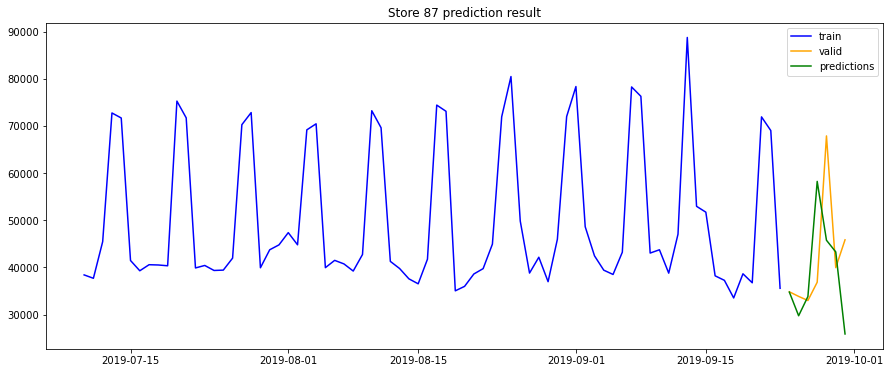

Order value for store 87 prediction is:

order :  (1, 1, 0)
seasonal_order :  (2, 0, 2, 7)
Performing stepwise search to minimize bic


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=1347.352, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1375.665, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1348.271, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=1351.859, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1371.366, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : BIC=1356.008, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : BIC=1350.543, Time=0.29 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : BIC=1351.423, Time=1.44 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : BIC=1351.358, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : BIC=1357.097, Time=0.25 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : BIC=1352.268, Time=0.46 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : BIC=inf, Time=2.58 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=1343.309, Time=0.55 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : BIC=1347.848, Time=0.06 sec
 ARIMA(0,1,1)(2,0,1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


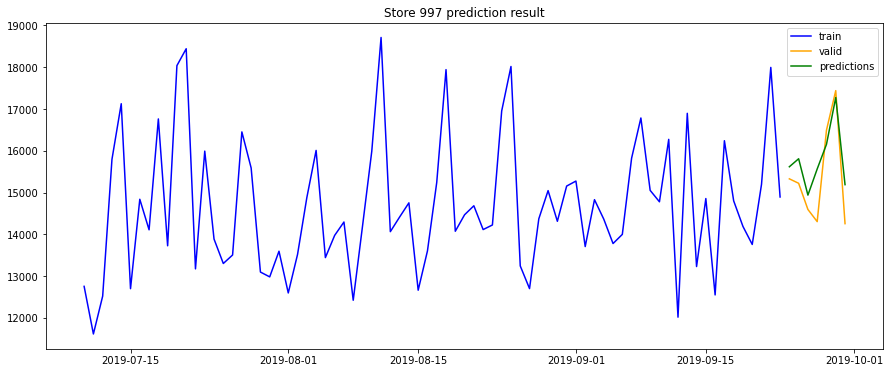

Order value for store 997 prediction is:

order :  (0, 1, 1)
seasonal_order :  (1, 0, 1, 7)


In [31]:
for i in sample_sites:
    ts = timeseries[i]
    df_train = ts[start_dataset:start_predict-1]
    df_predict=ts[start_predict:end_predict-1]
    model = pm.auto_arima(df_train, trace=True, seasonal=True, d=1, start_p=1, max_p =10, start_q=1, max_q=10, m=7, maxiter=500, random=False, n_fits=100, n_jobs =8, information_criterion ='bic', error_action='ignore', suppress_warning=True)
    forecast = model.predict(n_periods=7)
    order = model.get_params()["order"]
    seasonal_order = model.get_params()["seasonal_order"]
    plot_predictions(forecast, i)
    print('Order value for store %s prediction is:\n' %i)
    print('order : ', order)
    print('seasonal_order : ', seasonal_order)